# FITS handling and extracting needed information from the data prior to modeling
This notebook gives an example of reading in data from a fits file and performing a modeling. Please note: lenstronomy is a modeling and analysis software package. The handling of the data, reductions and the extraction of the relevant quantities from the data are in the responsibility of the user. The examples provided here may be used as orientation for new users.

- General fits handling with astropy can be found here: https://docs.astropy.org/en/stable/io/fits/
- Information about astropy coordinate systems can be found here:
http://docs.astropy.org/en/stable/wcs/
- For the units and coordinate system description of lenstronomy, see the following Jupyter Notebook:
https://github.com/sibirrer/lenstronomy_extensions/blob/main/lenstronomy_extensions/Notebooks/units_coordinates_parameters.ipynb
- For reduction of HST data you may find useful Notebooks here: https://github.com/ajshajib/hst-lens



In [1]:
# make sure lenstronomy is installed, otherwise install the latest pip version
try:
    import lenstronomy
except:
    !pip install lenstronomy

## coordinate system from fits header
Most fits data formats suport the WCS class of astropy and distortion corrected pixel to coordinate transformations are supported. lenstronomy currently only supports linear transformations. This is in most cases sufficient if the linear transformations are computed at the position of the lens in the image.

The linear transformations are often marked in the header of the fits file in units of degrees.

In [1]:
# header entries for the linear transformation (from a HST data header)
header = {'CD1_1': 5.73840710288063E-06, 
          'CD1_2': 1.26468148676247E-05, 
          'CD2_1': 1.26468146588748E-05, 
          'CD2_2': -5.7384070845446E-06,
          'NAXIS1': 4244,
          'NAXIS2': 4477
         }

# read out matrix elements and convert them in units of arc seconds
CD1_1 = header.get('CD1_1') * 3600  # change in arc sec per pixel d(ra)/dx
CD1_2 = header.get('CD1_2') * 3600
CD2_1 = header.get('CD2_1') * 3600
CD2_2 = header.get('CD2_2') * 3600

# generate pixel-to-coordinate transform matrix and its inverse
import numpy as np
pix2coord_transform_undistorted = np.array([[CD1_1, CD1_2], [CD2_1, CD2_2]])
det = CD1_1*CD2_2 - CD1_2*CD2_1
coord2pix_transform_undistorted = np.array([[CD2_2, -CD1_2], [-CD2_1, CD1_1]])/det

# as an example, we set the coordinate zero point in the center of the image and compute 
# the coordinate at the pixel (0,0) at the edge of the image

# read out pixel size of image
nx = header.get('NAXIS1')
ny = header.get('NAXIS2')
x_c = int(nx / 2)
y_c = int(ny / 2)

# compute RA/DEC relative shift between the edge and the center of the image
dra, ddec = pix2coord_transform_undistorted.dot(np.array([x_c, y_c]))
# set edge of the image such that the center has RA/DEC = (0,0)
ra_at_xy_0, dec_at_xy_0 = -dra, -ddec

Hints:
- Pay attention with conversion of absolute coordinates on the sky to relative coordinates (right ascention has a scaling with declination).
- Set the coordinate system conveniently and well defined, e.g. with a zero point in the center of an object.

## noise properties from data
Noise properties can be estimated from the data. The noise implementation in lenstronomy uses a Gaussian noise component that is uniform and a Poissonian shot noise component that is directly related to the total number of independent photons hitting the detector.
- The Gaussian component can be estimated by e.g. computing the r.m.s. value of the pixel values in regions where no (or neglible) signal is expected.
- The Poissonian noise component requires the total counts per pixel, which is the exposure time x pixel values (if the units are in photons/time). Attention: sometimes the units are in ADU units and require a CCD gain conversion.


Attention: 
- Noise properties can be correlated, depending also on the data reduction steps undertaken. This notebook is not meant to be a data reduction tutorial.
- Be careful in checking the noise properties and units in your data. This is an important step in conduction scientific investigation and only a valid data product allows to derive a probabilistic statement.

## point spread function (PSF) estimate
The point spread function of the observations is a required and crucial component of any imaging modeling. The reliable extraction of this quantity from the data may be hard. The commonly used strategies are:
- Using a PSF library from derived or simulated products provided.
- Using nearby point sources (e.g. stars) to estimate the PSF.
In some work, an iterative correction of the PSF has been performed. lenstronomy has support for this (but may not work in all circumstances and is rather involved).


Attention:
- The PSF can vary over the scale of an image.
- The PSF is generally wave-length dependent and different SED objects may have slightly different PSF.
- The PSF imported into lenstronomy is assumed to be a point source emission at the center of the central pixel. If the PSF imported is off-centered, this can lead to bad fitting results.
- Do not de-convolve your image. lenstronomy performs best if the data product is untouched and the convolution is performed on the model. De-convolution is model dependent and generally there exists no unique solution.

Below is an example of how a pixelized PSF is imported in the PSF() class. For more details and options of PSF models, we refer to the documentation of the PSF() class.

/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10


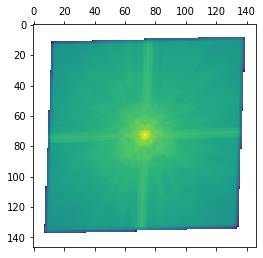

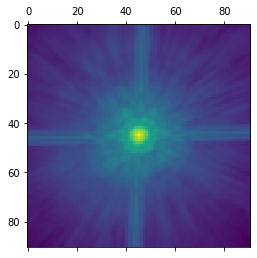

In [2]:
# import PSF file (here as a relative path in the lenstronomy_extension repository)
# the psf_example.fits file can be found here:
# https://github.com/sibirrer/lenstronomy_extensions/tree/main/Data/PSF_TinyTim
# and imported from a local file path as well

import os
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
%matplotlib inline


path = os.getcwd()
dirpath, _ = os.path.split(path)
module_path, _ = os.path.split(dirpath)
psf_filename = os.path.join(module_path, 'Data/PSF_TinyTim/psf_example.fits')
kernel = pyfits.getdata(psf_filename)

plt.matshow(np.log10(kernel))
plt.show()

psf_type = 'PIXEL'  # 'gaussian', 'pixel', 'NONE'
kernel_size = 91

from lenstronomy.Data.psf import PSF
from lenstronomy.Util import kernel_util
kernel_cut = kernel_util.cut_psf(kernel, kernel_size)
kwargs_psf = {'psf_type': psf_type, 'kernel_point_source': kernel_cut}
psf_class = PSF(**kwargs_psf)

kernel_psf_class = psf_class.kernel_point_source

plt.matshow(np.log10(kernel_psf_class))
plt.show()